## Proofreading - Figure 5 and Ext. Data Figure 6

This notebook creates the plots presented in Figure 4 of the FlyWire paper. 

In [1]:
import os
import dill
import warnings
import pandas as pd
import collections
import numpy as np

warnings.filterwarnings("ignore")

HOME = os.path.expanduser("~")

In [2]:
from flywirepaper import plotting

## Define relevant paths and create directories

In [3]:
data_dir = f"{os.path.realpath('')}/../data"
figure_dir = f"{os.path.realpath('')}/../figures/figure_5/"
figure_source_dir = f"{os.path.realpath('')}/../figures/figure_source_5/"

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
    
if not os.path.exists(figure_source_dir):
    os.makedirs(figure_source_dir)

## Data loading

This cell loads the data of the three-round proofreading. Each cell was proofread successively by three different proofreaders.

`proofreading_round_root_id_dict`: Contains the root_ids before and after each proofreading round. The key is a unique identifier for the cell, the values is a list of four root_ids. 

`proofreading_round_vx_change_dict`: Contains voxel changes of each edit applied to the cell in each round. The key is a unique identifier for the cell, the next key is the proofreading round. We removed edits that were later undone by a proofreader and those that were made to a branch that was later cut-off from the neuron (see Methods). Values are the change in voxels that an edit caused. 

`proofreading_round_nsyn_change_dict`: Similar to above. Values are the change in number of synapses that an edit caused. Prior to calculating changes, synapses were filtered with a threshold of 50 (`>=`) on the cleft score (see Methods).

In [4]:
with open(f"{data_dir}/proofreading_round_root_id_dict.dl", "rb") as f:
    proofreading_round_root_id_dict = dill.load(f)
with open(f"{data_dir}/proofreading_round_vx_change_dict.dl", "rb") as f:
    proofreading_round_vx_change_dict = dill.load(f)
with open(f"{data_dir}/proofreading_round_nsyn_change_dict.dl", "rb") as f:
    proofreading_round_nsyn_change_dict = dill.load(f)

`nvx_performance_dict`: Contains true and false positive and negative voxels for each neuron before every proofreading round when compared to the final root_id.

`nsyn_performance_dict`: Contains true and false positive and negative synapses (both in- and outgoing) for each neuron before every proofreading round when compared to the final root_id.

`nvx_fast_performance_dict` and `nsyn_fast_performance_dict` contain analogous data for the additional evaluation of the fast proofreading regiment.

In [5]:
with open(f"{data_dir}/nvx_performance_dict.dl", "rb") as f:
    nvx_performance_dict = dill.load(f)
    
with open(f"{data_dir}/nsyn_performance_dict.dl", "rb") as f:
    nsyn_performance_dict = dill.load(f)
    
with open(f"{data_dir}/nvx_fast_performance_dict.dl", "rb") as f:
    nvx_fast_performance_dict = dill.load(f)
    
with open(f"{data_dir}/nsyn_fast_performance_dict.dl", "rb") as f:
    nsyn_fast_performance_dict = dill.load(f)

## Global definitions

In [6]:
round_colors = [".4", [.6, .3, .3], [.1, .4, .8], [.5, .5, .1], [.7, .3, .7]]
round_labels = {0: "Auto", 1: "1", 2: "2", 3: "3"}
round_labels_ext = {0: "Auto", 1: "1rnd", 2: "2rnds", 100: "Fast"}
vx_um_size = 16 * 16 * 40 / 1e9

## Calculating number of edits per proofreading round

Combining edits across neurons and collecting statistics per proofreading round. Here, we are calculating the number of edits per proofreading round, filter for major edits ($ >1\mu m^3$), and summarize proofreading times.

In [7]:
major_threshold = 1.

In [8]:
consolidated_vx_changes = collections.defaultdict(list)
consolidated_nsyn_changes = collections.defaultdict(list)

for i_round in range(1, 4):
    for u_id in proofreading_round_vx_change_dict.keys():
        if i_round in proofreading_round_vx_change_dict[u_id]:
            consolidated_vx_changes[i_round].extend(proofreading_round_vx_change_dict[u_id][i_round])
        if i_round in proofreading_round_nsyn_change_dict[u_id]:
            consolidated_nsyn_changes[i_round].extend(proofreading_round_nsyn_change_dict[u_id][i_round])

In [9]:
n_major_edits_dict = collections.defaultdict(dict)
n_edits_dict = collections.defaultdict(dict)
edits_uid_dict = collections.defaultdict(dict)
proofreading_time_edits_dict = collections.defaultdict(dict)


for u_id in proofreading_round_vx_change_dict:
    for k in range(1, 4):            
        n_major_edits_dict[k][u_id] = np.sum((np.abs(proofreading_round_vx_change_dict[u_id][k]) * vx_um_size) > major_threshold)
        n_edits_dict[k][u_id] = len(proofreading_round_vx_change_dict[u_id][k])

In [10]:
n_major_edits_df = pd.DataFrame(n_major_edits_dict)
n_edits_df = pd.DataFrame(n_major_edits_dict)

## Plotting number of edits per proofreading round

Creating a summary dataframe

In [11]:
n_edits_df.describe()

,1,2,3
count,183.000000,183.000000,183.000000
mean,10.945355,2.540984,2.551913
std,13.249809,4.394954,5.352034
min,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,7.000000,1.000000,0.000000
75%,13.000000,3.000000,3.000000
max,94.000000,31.000000,36.000000


In [12]:
n_major_edits_df.describe()

,1,2,3
count,183.000000,183.000000,183.000000
mean,10.945355,2.540984,2.551913
std,13.249809,4.394954,5.352034
min,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,7.000000,1.000000,0.000000
75%,13.000000,3.000000,3.000000
max,94.000000,31.000000,36.000000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


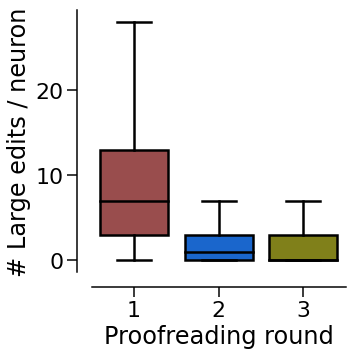

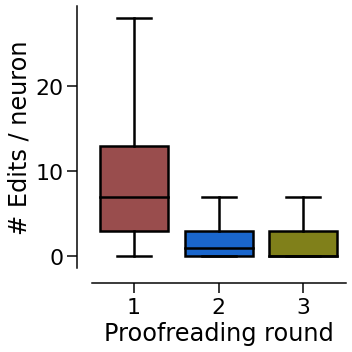

In [13]:
plotting.box_plot(n_major_edits_df.to_dict(orient="list"),
                  color_list=round_colors[1:], 
                  figsize=((5, 5)),
                  xlabel="Proofreading round",
                  ylabel="# Large edits / neuron",
                  path=f"{figure_dir}/edit_major_box.png")

plotting.box_plot(n_edits_df.to_dict(orient="list"), 
                  color_list=round_colors[1:], 
                  figsize=(5, 5),
                  xlabel="Proofreading round", 
                  ylabel="# Edits / neuron",
                  path=f"{figure_dir}/edit_number_box.png")

In [14]:
source_data_a_df = pd.DataFrame.from_dict(n_major_edits_dict, orient="index").T
source_data_b_df = pd.DataFrame.from_dict(n_edits_dict, orient="index").T

In [15]:
source_data_a_df.to_csv(f"{figure_source_dir}/a_source.csv")
source_data_b_df.to_csv(f"{figure_source_dir}/b_source.csv")

## Calculating proofreading performance

In [16]:
def calc_performance(tp, fn, fp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    fscore = 2 * precision * recall / (precision + recall)
    if isinstance(fscore, np.ndarray):
        fscore[np.isnan(fscore)] = 0
    else:
        if np.isnan(fscore):
            fscore = 0
    
    return precision, recall, fscore
    
consolidated_nvx_performance_dict = collections.defaultdict(list)
consolidated_nsyn_performance_dict = collections.defaultdict(list)
for u_id in nvx_performance_dict.keys():
    for i_round in range(3):
        vx_entry = nvx_performance_dict[u_id][i_round]
        vx_p, vx_r, vx_f = calc_performance(vx_entry["tp_nvx"], vx_entry["fn_nvx"], vx_entry["fp_nvx"])
        vx_entry["vx_precision"] = vx_p
        vx_entry["vx_recall"] = vx_r
        vx_entry["vx_fscore"] = vx_f
        consolidated_nvx_performance_dict[i_round].append(vx_entry)
        
        nsyn_entry = nsyn_performance_dict[u_id][i_round]
        nsyn_p, nsyn_r, nsyn_f = calc_performance(np.array(nsyn_entry["tp_nsyn"]), 
                                                  np.array(nsyn_entry["fn_nsyn"]), 
                                                  np.array(nsyn_entry["fp_nsyn"]))
        nsyn_entry["nsyn_precision"] = nsyn_p
        nsyn_entry["nsyn_recall"] = nsyn_r
        nsyn_entry["nsyn_fscore"] = nsyn_f
        nsyn_p, nsyn_r, nsyn_f = calc_performance(np.sum(nsyn_entry["tp_nsyn"]), 
                                                  np.sum(nsyn_entry["fn_nsyn"]), 
                                                  np.sum(nsyn_entry["fp_nsyn"]))
        nsyn_entry["nsyn_sum_precision"] = nsyn_p
        nsyn_entry["nsyn_sum_recall"] = nsyn_r
        nsyn_entry["nsyn_sum_fscore"] = nsyn_f
        consolidated_nsyn_performance_dict[i_round].append(nsyn_entry)

## Plotting proofreading performances

In [17]:
perf_results = pd.DataFrame.from_dict({
    "round": range(0, 3), 
    "mean(F1_vx)": [np.mean([e["vx_fscore"] for e in consolidated_nvx_performance_dict[k]]) for k in range(3)],
    "median(F1_vx)": [np.median([e["vx_fscore"] for e in consolidated_nvx_performance_dict[k]]) for k in range(3)],
    "mean(F1_syn)": [np.mean([e["nsyn_sum_fscore"] for e in consolidated_nsyn_performance_dict[k]]) for k in range(3)],
    "median(F1_syn)": [np.median([e["nsyn_sum_fscore"] for e in consolidated_nsyn_performance_dict[k]]) for k in range(3)],
}).set_index("round")

In [18]:
perf_results.round(3)

,mean(F1_vx),median(F1_vx),mean(F1_syn),median(F1_syn)
round,,,,
0,0.665,0.730,0.642,0.724
1,0.968,0.989,0.942,0.988
2,0.984,0.999,0.970,0.998


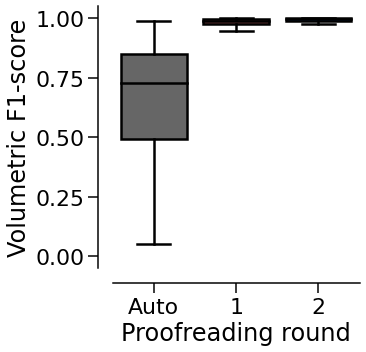

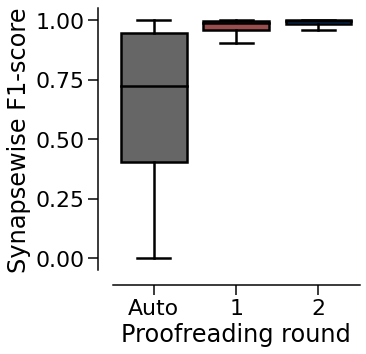

In [19]:
data_dict_nvx = {round_labels[k]: [e["vx_fscore"] for e in consolidated_nvx_performance_dict[k]] for k in consolidated_nvx_performance_dict}
data_dict_nsyn = {round_labels[k]: [e["nsyn_sum_fscore"] for e in consolidated_nsyn_performance_dict[k]] for k in consolidated_nsyn_performance_dict} 

plotting.box_plot(data_dict_nvx,
                  color_list=round_colors, 
                  ylabel="Volumetric F1-score",
                  figsize=(5, 5),
                  xlabel="Proofreading round",
                  path=f"{figure_dir}/volumetric_fscore_box.png",
                  yrange=[-0.05, 1.05])

plotting.box_plot(data_dict_nsyn,
                  color_list=round_colors, 
                  ylabel="Synapsewise F1-score", 
                  figsize=(5, 5), 
                  xlabel="Proofreading round",
                  path=f"{figure_dir}/synapsewise_fscore_box.png", 
                  yrange=[-0.05, 1.05])

In [20]:
source_data_c_df = pd.DataFrame.from_dict(data_dict_nvx, orient="index").T
source_data_d_df = pd.DataFrame.from_dict(data_dict_nsyn, orient="index").T

In [21]:
source_data_c_df.to_csv(f"{figure_source_dir}/c_source.csv")
source_data_d_df.to_csv(f"{figure_source_dir}/d_source.csv")

## Faster proofreading

Similar to above, we calculate the scores for the fast proofreading rounds.

Not all neurons were included in the fast proofreading regiment. We combine the scores from the fast proofreading approach with the scores from the standard proofreading by selecting the scores for the neurons that were included in both.

In [22]:
combined_nvx_performance_dict = collections.defaultdict(list)
combined_nsyn_performance_dict = collections.defaultdict(list)

for u_id in nvx_fast_performance_dict.keys():
    vx_entry = nvx_fast_performance_dict[u_id]
    vx_p, vx_r, vx_f = calc_performance(vx_entry["tp_nvx"], vx_entry["fn_nvx"], vx_entry["fp_nvx"])
    vx_entry["vx_precision"] = vx_p
    vx_entry["vx_recall"] = vx_r
    vx_entry["vx_fscore"] = vx_f
    combined_nvx_performance_dict[100].append(vx_entry)

    nsyn_entry = nsyn_fast_performance_dict[u_id]
    nsyn_p, nsyn_r, nsyn_f = calc_performance(np.array(nsyn_entry["tp_nsyn"]), 
                                              np.array(nsyn_entry["fn_nsyn"]), 
                                              np.array(nsyn_entry["fp_nsyn"]))
    nsyn_entry["nsyn_precision"] = nsyn_p
    nsyn_entry["nsyn_recall"] = nsyn_r
    nsyn_entry["nsyn_fscore"] = nsyn_f
    nsyn_p, nsyn_r, nsyn_f = calc_performance(np.sum(nsyn_entry["tp_nsyn"]), 
                                              np.sum(nsyn_entry["fn_nsyn"]), 
                                              np.sum(nsyn_entry["fp_nsyn"]))
    nsyn_entry["nsyn_sum_precision"] = nsyn_p
    nsyn_entry["nsyn_sum_recall"] = nsyn_r
    nsyn_entry["nsyn_sum_fscore"] = nsyn_f
    combined_nsyn_performance_dict[100].append(nsyn_entry)
    
    
    for i_round in range(3):
        vx_entry = nvx_performance_dict[u_id][i_round]
        vx_p, vx_r, vx_f = calc_performance(vx_entry["tp_nvx"], vx_entry["fn_nvx"], vx_entry["fp_nvx"])
        vx_entry["vx_precision"] = vx_p
        vx_entry["vx_recall"] = vx_r
        vx_entry["vx_fscore"] = vx_f
        combined_nvx_performance_dict[i_round].append(vx_entry)

        nsyn_entry = nsyn_performance_dict[u_id][i_round]
        nsyn_p, nsyn_r, nsyn_f = calc_performance(np.array(nsyn_entry["tp_nsyn"]), 
                                                  np.array(nsyn_entry["fn_nsyn"]), 
                                                  np.array(nsyn_entry["fp_nsyn"]))
        nsyn_entry["nsyn_precision"] = nsyn_p
        nsyn_entry["nsyn_recall"] = nsyn_r
        nsyn_entry["nsyn_fscore"] = nsyn_f
        nsyn_p, nsyn_r, nsyn_f = calc_performance(np.sum(nsyn_entry["tp_nsyn"]), 
                                                  np.sum(nsyn_entry["fn_nsyn"]), 
                                                  np.sum(nsyn_entry["fp_nsyn"]))
        nsyn_entry["nsyn_sum_precision"] = nsyn_p
        nsyn_entry["nsyn_sum_recall"] = nsyn_r
        nsyn_entry["nsyn_sum_fscore"] = nsyn_f
        combined_nsyn_performance_dict[i_round].append(nsyn_entry)

## Plotting faster proofreading performances

In [23]:
perf_results = pd.DataFrame.from_dict({
    "round": [0, 1, 2, "fast"], 
    "mean(F1_vx)": [np.mean([e["vx_fscore"] for e in combined_nvx_performance_dict[k]]) for k in [0, 1, 2, 100]],
    "median(F1_vx)": [np.median([e["vx_fscore"] for e in combined_nvx_performance_dict[k]]) for k in [0, 1, 2, 100]],
    "mean(F1_syn)": [np.mean([e["nsyn_sum_fscore"] for e in combined_nsyn_performance_dict[k]]) for k in [0, 1, 2, 100]],
    "median(F1_syn)": [np.median([e["nsyn_sum_fscore"] for e in combined_nsyn_performance_dict[k]]) for k in [0, 1, 2, 100]],
}).set_index("round")

In [24]:
perf_results.round(3)

,mean(F1_vx),median(F1_vx),mean(F1_syn),median(F1_syn)
round,,,,
0,0.729,0.777,0.746,0.799
1,0.975,0.992,0.958,0.992
2,0.992,0.999,0.986,0.999
fast,0.968,0.988,0.945,0.988


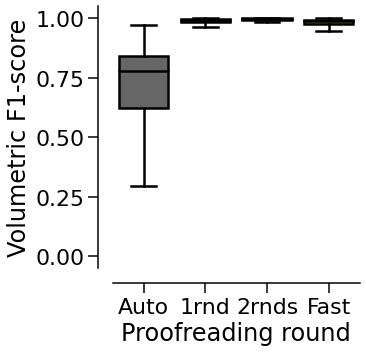

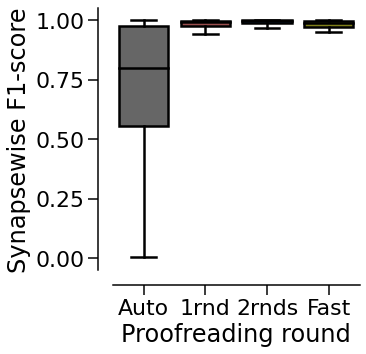

In [25]:
data_dict_nvx = {round_labels_ext[k]: [e["vx_fscore"] for e in combined_nvx_performance_dict[k]] for k in np.sort(list(combined_nvx_performance_dict))}
data_dict_nsyn = {round_labels_ext[k]: [e["nsyn_sum_fscore"] for e in combined_nsyn_performance_dict[k]] for k in np.sort(list(combined_nsyn_performance_dict))} 

plotting.box_plot(data_dict_nvx,
                  color_list=round_colors, 
                  ylabel="Volumetric F1-score",
                  figsize=(5, 5),
                  xlabel="Proofreading round",
                  path=f"{figure_dir}/volumetric_fscore_box_fast.png",
                  yrange=[-0.05, 1.05])

plotting.box_plot(data_dict_nsyn,
                  color_list=round_colors, 
                  ylabel="Synapsewise F1-score", 
                  figsize=(5, 5), 
                  xlabel="Proofreading round",
                  path=f"{figure_dir}/synapsewise_fscore_box_fast.png", 
                  yrange=[-0.05, 1.05])

In [26]:
source_data_ext_a_df = pd.DataFrame.from_dict(data_dict_nvx, orient="index").T
source_data_ext_b_df = pd.DataFrame.from_dict(data_dict_nsyn, orient="index").T

In [27]:
source_data_ext_a_df.to_csv(f"{figure_source_dir}/ext_a_source.csv")
source_data_ext_b_df.to_csv(f"{figure_source_dir}/ext_b_source.csv")